In [1]:
%matplotlib inline

In [2]:
import numpy as np
import warnings
import pathlib as pal
import pandas as pd

from matplotlib import pyplot as plt
from matplotlib import gridspec
from scipy.stats import bootstrap

In [3]:
warnings.filterwarnings("ignore", category=UserWarning, message="There are no gridspecs with layoutgrids")

In [4]:
def get_ppv(sens, spec, prev):
    tp = sens * prev
    tn = spec * (1-prev)
    fp = (1-spec) * (1-prev)
    fn = (1-sens) * prev
    ppv = tp/(tp+fp)
    return ppv

def get_acc(sens, spec, prev):
    tp = sens * prev
    tn = spec * (1-prev)
    fp = (1-spec) * (1-prev)
    fn = (1-sens) * prev
    acc = (tp+tn)/(tp+fp+tn+fn)
    return acc

def get_or(sens, spec, prev):
    tp = sens * prev
    tn = spec * (1-prev)
    fp = (1-spec) * (1-prev)
    fn = (1-sens) * prev
    OR = (tp/fp)/(fn/tn)
    return OR

def get_rr(sens, spec, prev):
    tp = sens * prev
    tn = spec * (1-prev)
    fp = (1-spec) * (1-prev)
    fn = (1-sens) * prev
    RR = (tp/(fp+tp))/(fn/(fn+tn))
    return RR

In [5]:
def calculate_bootstrap_ci(sens_dist, spec_dist, prev_range, metric_func, n_boot=100):
    """Calculate median and botstrap CI for a given metric, across prevalence range"""
    medians = []
    lower = []
    upper = []
    
    for prev in prev_range:
        # Calculate metric for all bootstrap samples at this prevalence
        metric_dist = [metric_func(sens, spec, prev) 
                       for sens, spec in zip(sens_dist, spec_dist)]
        
        # Compute statistics
        medians.append(np.median(metric_dist))
        ci = bootstrap((metric_dist,), np.median, method='BCa', n_resamples=n_boot).confidence_interval
        lower.append(ci.low)
        upper.append(ci.high)
    
    return np.array(medians), np.array(lower), np.array(upper)

In [16]:
# Load bootstrap results
root_p = pal.Path('/home/neuromod/ASD_project_clean')
bootstrap_p = root_p / "Results/Discovery/table_split.csv"

fig_p = root_p / 'Figures'
fig_p.mkdir(parents=True, exist_ok=True) 

In [7]:
df = pd.read_csv(bootstrap_p)
group_1_data = df[df['network'] == 'group_1']

In [8]:
prev_range = np.logspace(-2, 0, 100)

In [9]:
# Calculate bootstrap CIs for all metrics
median_ppv, lower_ppv, upper_ppv = calculate_bootstrap_ci(
    group_1_data['sensitivity'], group_1_data['specificity'], prev_range, get_ppv)

median_acc, lower_acc, upper_acc = calculate_bootstrap_ci(
    group_1_data['sensitivity'], group_1_data['specificity'], prev_range, get_acc)

median_rr, lower_rr, upper_rr = calculate_bootstrap_ci(
    group_1_data['sensitivity'], group_1_data['specificity'], prev_range, get_rr)

/tmp/ipykernel_1064883/2668870428.py:6: RuntimeWarning: invalid value encountered in scalar divide
  ppv = tp/(tp+fp)
/home/neuromod/ASD_project_clean/env/lib/python3.10/site-packages/scipy/_lib/_util.py:440: DegenerateDataWarning: The BCa confidence interval cannot be calculated. This problem is known to occur when the distribution is degenerate or the statistic is np.min.
  return fun(*args, **kwargs)
/tmp/ipykernel_1064883/2668870428.py:30: RuntimeWarning: invalid value encountered in scalar divide
  RR = (tp/(fp+tp))/(fn/(fn+tn))


In [10]:
# Calculate Traut sensitivity and specificity from figure 2B of their paper, confirmatory approach
traut_tpr = 0.254
traut_fpr = 0.03

traut_sens = traut_tpr
traut_spec = 1-traut_fpr

In [11]:
# Base rate
print(1/90)

0.011111111111111112


In [12]:
mod_abraham = (0.61, 0.723) # Abraham model
mod_heinsfeld = (0.74, 0.63) # Heinsfeld model
mod_traut = (traut_sens, traut_spec) # Traut model

In [13]:
def mm2in(mm):
    return mm/25.4

In [14]:
from matplotlib import rcParams
rcParams['font.sans-serif'] = ['Arial']

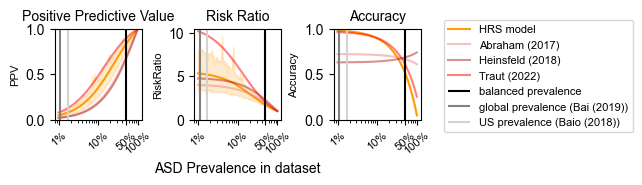

In [25]:
dpi=300
scale_factor = 1
height = 30 * scale_factor
width = 120 * scale_factor

f = plt.figure(figsize=(mm2in(width),mm2in(height)), constrained_layout=True)
gs = gridspec.GridSpec(nrows=1, ncols=3, wspace=0.6)
ax1 = f.add_subplot(gs[0])
ax2 = f.add_subplot(gs[2])
ax3 = f.add_subplot(gs[1])

# Plot PPV with bootstrap CI
ax1.plot(prev_range, median_ppv, label='HRS model', color='#FE9D08')
ax1.fill_between(prev_range, lower_ppv, upper_ppv, color='#FE9D08', alpha=0.2)
ax1.plot(prev_range, [get_ppv(*mod_abraham, prev) for prev in prev_range], label='Abraham (2017)', color="lightcoral", alpha=0.5)
ax1.plot(prev_range, [get_ppv(*mod_heinsfeld, prev) for prev in prev_range], label='Heinsfeld (2018)', color="firebrick", alpha=0.5)
ax1.plot(prev_range, [get_ppv(*mod_traut, prev) for prev in prev_range], label='Traut (2022)', color="red", alpha=0.5)

ax1.vlines(0.5, 0, 1, color='black')
ax1.vlines(0.011, 0, 1, color='grey')
ax1.vlines(0.0169, 0, 1, color='lightgrey')
ax1.set_xscale('log')

ax1.set_xticks([0.01, 0.1, 0.5, 1])
ax1.set_yticks([0, 0.5, 1])

ax1.set_xticklabels([])
ax1.set_ylabel('PPV', fontsize=8)
ax1.set_xticklabels(['1%', '10%', '50%', '100%'], rotation=40, fontsize=8)

ax1.set_title('Positive Predictive Value', fontsize=10)
ax1.set_ylim(0, 1)

# Plot Accuracy with bootstrap CI
ax2.plot(prev_range, median_acc, label='HRS model', color='#FE9D08')
ax2.fill_between(prev_range, lower_acc, upper_acc, color='#FE9D08', alpha=0.2)
ax2.plot(prev_range, [get_acc(*mod_abraham, prev) for prev in prev_range], label='Abraham (2017)', color="lightcoral", alpha=0.5)
ax2.plot(prev_range, [get_acc(*mod_heinsfeld, prev) for prev in prev_range], label='Heinsfeld (2018)', color="firebrick", alpha=0.5)
ax2.plot(prev_range, [get_acc(*mod_traut, prev) for prev in prev_range], label='Traut (2022)', color="red", alpha=0.5)

ax2.vlines(0.5, 0, 1, color='black', label='balanced prevalence')
ax2.vlines(0.011, 0, 1, color='grey', label='global prevalence (Bai (2019))')
ax2.vlines(0.0169, 0, 1, color='lightgrey', label= 'US prevalence (Baio (2018))')
ax2.set_xscale('log')

ax2.set_xticks([0.01, 0.1, 0.5, 1])
ax2.set_yticks([0, 0.5, 1])
ax2.set_xticklabels([])
ax2.set_ylabel('Accuracy', fontsize=8)
ax2.set_xticklabels(['1%', '10%', '50%', '100%'], rotation=40, fontsize=8)

ax2.set_title('Accuracy', fontsize=10)
ax2.set_ylim(0, 1)

# Plot Risk Ratio with bootstrap CI
ax3.plot(prev_range, median_rr, label='HRS model', color='#FE9D08')
ax3.fill_between(prev_range, lower_rr, upper_rr, color='#FE9D08', alpha=0.2)
ax3.plot(prev_range, [get_rr(*mod_abraham, prev) for prev in prev_range], label='Abraham (2017)', color="lightcoral", alpha=0.5)
ax3.plot(prev_range, [get_rr(*mod_heinsfeld, prev) for prev in prev_range], label='Heinsfeld (2018)', color="firebrick", alpha=0.5)
ax3.plot(prev_range, [get_rr(*mod_traut, prev) for prev in prev_range], label='Traut (2022)', color="red", alpha=0.5)

ax3.vlines(0.5, 0, 10.5, color='black')
ax3.vlines(0.011, 0, 10.5, color='grey')
ax3.vlines(0.0169, 0, 10.5, color='lightgrey')
ax3.set_xscale('log')

ax3.set_ylabel('RiskRatio', fontsize=8)
ax3.set_xlabel('ASD Prevalence in dataset', fontsize=10)
ax3.set_xticks([0.01, 0.1, 0.5, 1])
ax3.set_xticklabels(['1%', '10%', '50%', '100%'], rotation=40, fontsize=8)
ax3.set_title('Risk Ratio', fontsize=10)
ax3.set_ylim(0, 10.5)

lgd = ax2.legend(loc='lower left', fontsize=8, bbox_to_anchor=(1.2, -0.2))
f.savefig(fig_p / 'fig2_supp_performance.png', bbox_extra_artists=(lgd,), dpi=300, transparent=True, bbox_inches='tight')
f.savefig(fig_p / 'fig2_supp_performance.svg', bbox_extra_artists=(lgd,), dpi=300, transparent=True, bbox_inches='tight')